In [3]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

import re
from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as pretrained_models
import wandb
from custom_datasets import dataset
from custom_models import models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

wandb_api.login()
api = wandb.Api()
run_name = "1widym57"
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
config = run.config

use_cuda = torch.cuda.is_available()
config["device"] = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {config['device']}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [4]:
config


{'seed': 42,
 'device': device(type='cpu'),
 'epochs': 138,
 'job_type': 'train',
 'momentum': 0.9,
 'log_wandb': True,
 'loss_type': 'torch.nn.modules.loss.L1Loss',
 'batch_size': 64,
 'frac_noise': 0,
 'model_type': '__main__.PreTrainedVGG',
 'frac_sample': 1,
 'input_width': 64,
 'architecture': 'pretrained VGG',
 'fixed_layers': 0,
 'total_layers': 44,
 'weight_decay': 5e-05,
 'learning_rate': 0.0001,
 'optimizer_type': 'torch.optim.adam.Adam',
 'train_val_split': 0.7,
 'nb_image_per_axis': 3}

In [5]:
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
root_path = Path("tmp/")

model_script = run.file("model_script.txt")
model_script = model_script.download(root=root_path / run.name, replace=True)
model_script.seek(0)

datamodule_script = run.file("datamodule_script.txt")
datamodule_script = datamodule_script.download(root=root_path / run.name, replace=True)
datamodule_script.seek(0)

checkpoint = run.file("epoch=137-val_loss=0.045.ckpt")
checkpoint.download(root=root_path / run.name, replace=True)

model_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", model_script.read())[0]
model_script.seek(0)
datamodule_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", datamodule_script.read())[
    0
]
datamodule_script.seek(0)
with open(model_script.name, "r") as file:
    exec(file.read())
with open(datamodule_script.name, "r") as file:
    exec(file.read())


In [6]:
dm = eval(datamodule_name)(config=config, repo_path=repo_path)
model = eval(model_name).load_from_checkpoint(
    root_path / run.name / checkpoint.name, config=run.config
)
trainer = pl.Trainer(devices="auto", accelerator="auto")
predictions = torch.cat(trainer.predict(model, datamodule=dm))
targets = torch.cat([label for _, label in dm.val_dataloader()])


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

In [11]:
print("VALIDATION ON 'XYZ' ORDER ON NORMALIZED FABRICS")
print(training.metrics_str(predictions[:, 2:], targets[:, 2:]))
print("VALIDATION ON 'XYZ' ORDER ON UNNORMALIZED FABRICS")
print(
    training.metrics_str(
        dm.scaler.inverse_transform(predictions)[:, 2:],
        dm.scaler.inverse_transform(targets)[:, 2:],
    )
)


VALIDATION ON 'XYZ' ORDER ON NORMALIZED FABRICS
COSINE SIMILARITY: 0.993552565574646
R2 SCORE: 0.828411877155304
SMAPE: 0.14632152020931244
MAPE: 226.16615295410156
MAE: 0.04555084928870201
MSE: 0.004911746829748154
LOSS: 0.04555084928870201
_______________________________________________________________
VALIDATION ON 'XYZ' ORDER ON UNNORMALIZED FABRICS
COSINE SIMILARITY: 0.9998971819877625
R2 SCORE: 0.8284175992012024
SMAPE: 0.21957284212112427
MAPE: 1.1578948497772217
MAE: 0.021893242374062538
MSE: 0.0046053980477154255
LOSS: 0.021893242374062538
_______________________________________________________________


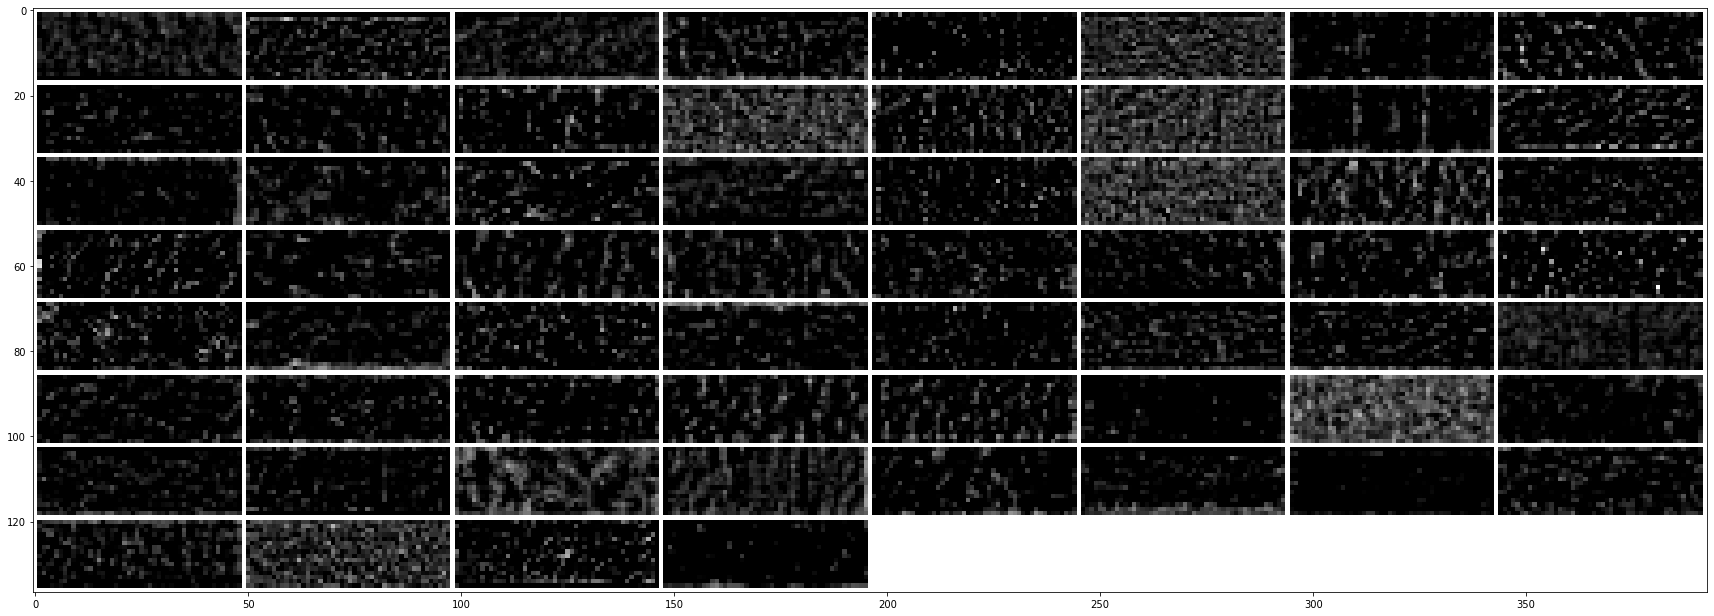

In [ ]:
save_output = training.SaveOutput()
handle = model.layers[15].register_forward_hook(save_output)
images, labels = next(iter(dm.val_dataloader()))
image = images[0]
model(image.unsqueeze(0))
handle.remove()
outputs = save_output.outputs[0].permute(1, 0, 2, 3).detach().cpu()[:60]
grid_img = utils.make_grid(outputs, normalize=True, pad_value=1, padding=1)
plt.figure(figsize=(30, 30))
plt.imshow(grid_img.permute(1, 2, 0))


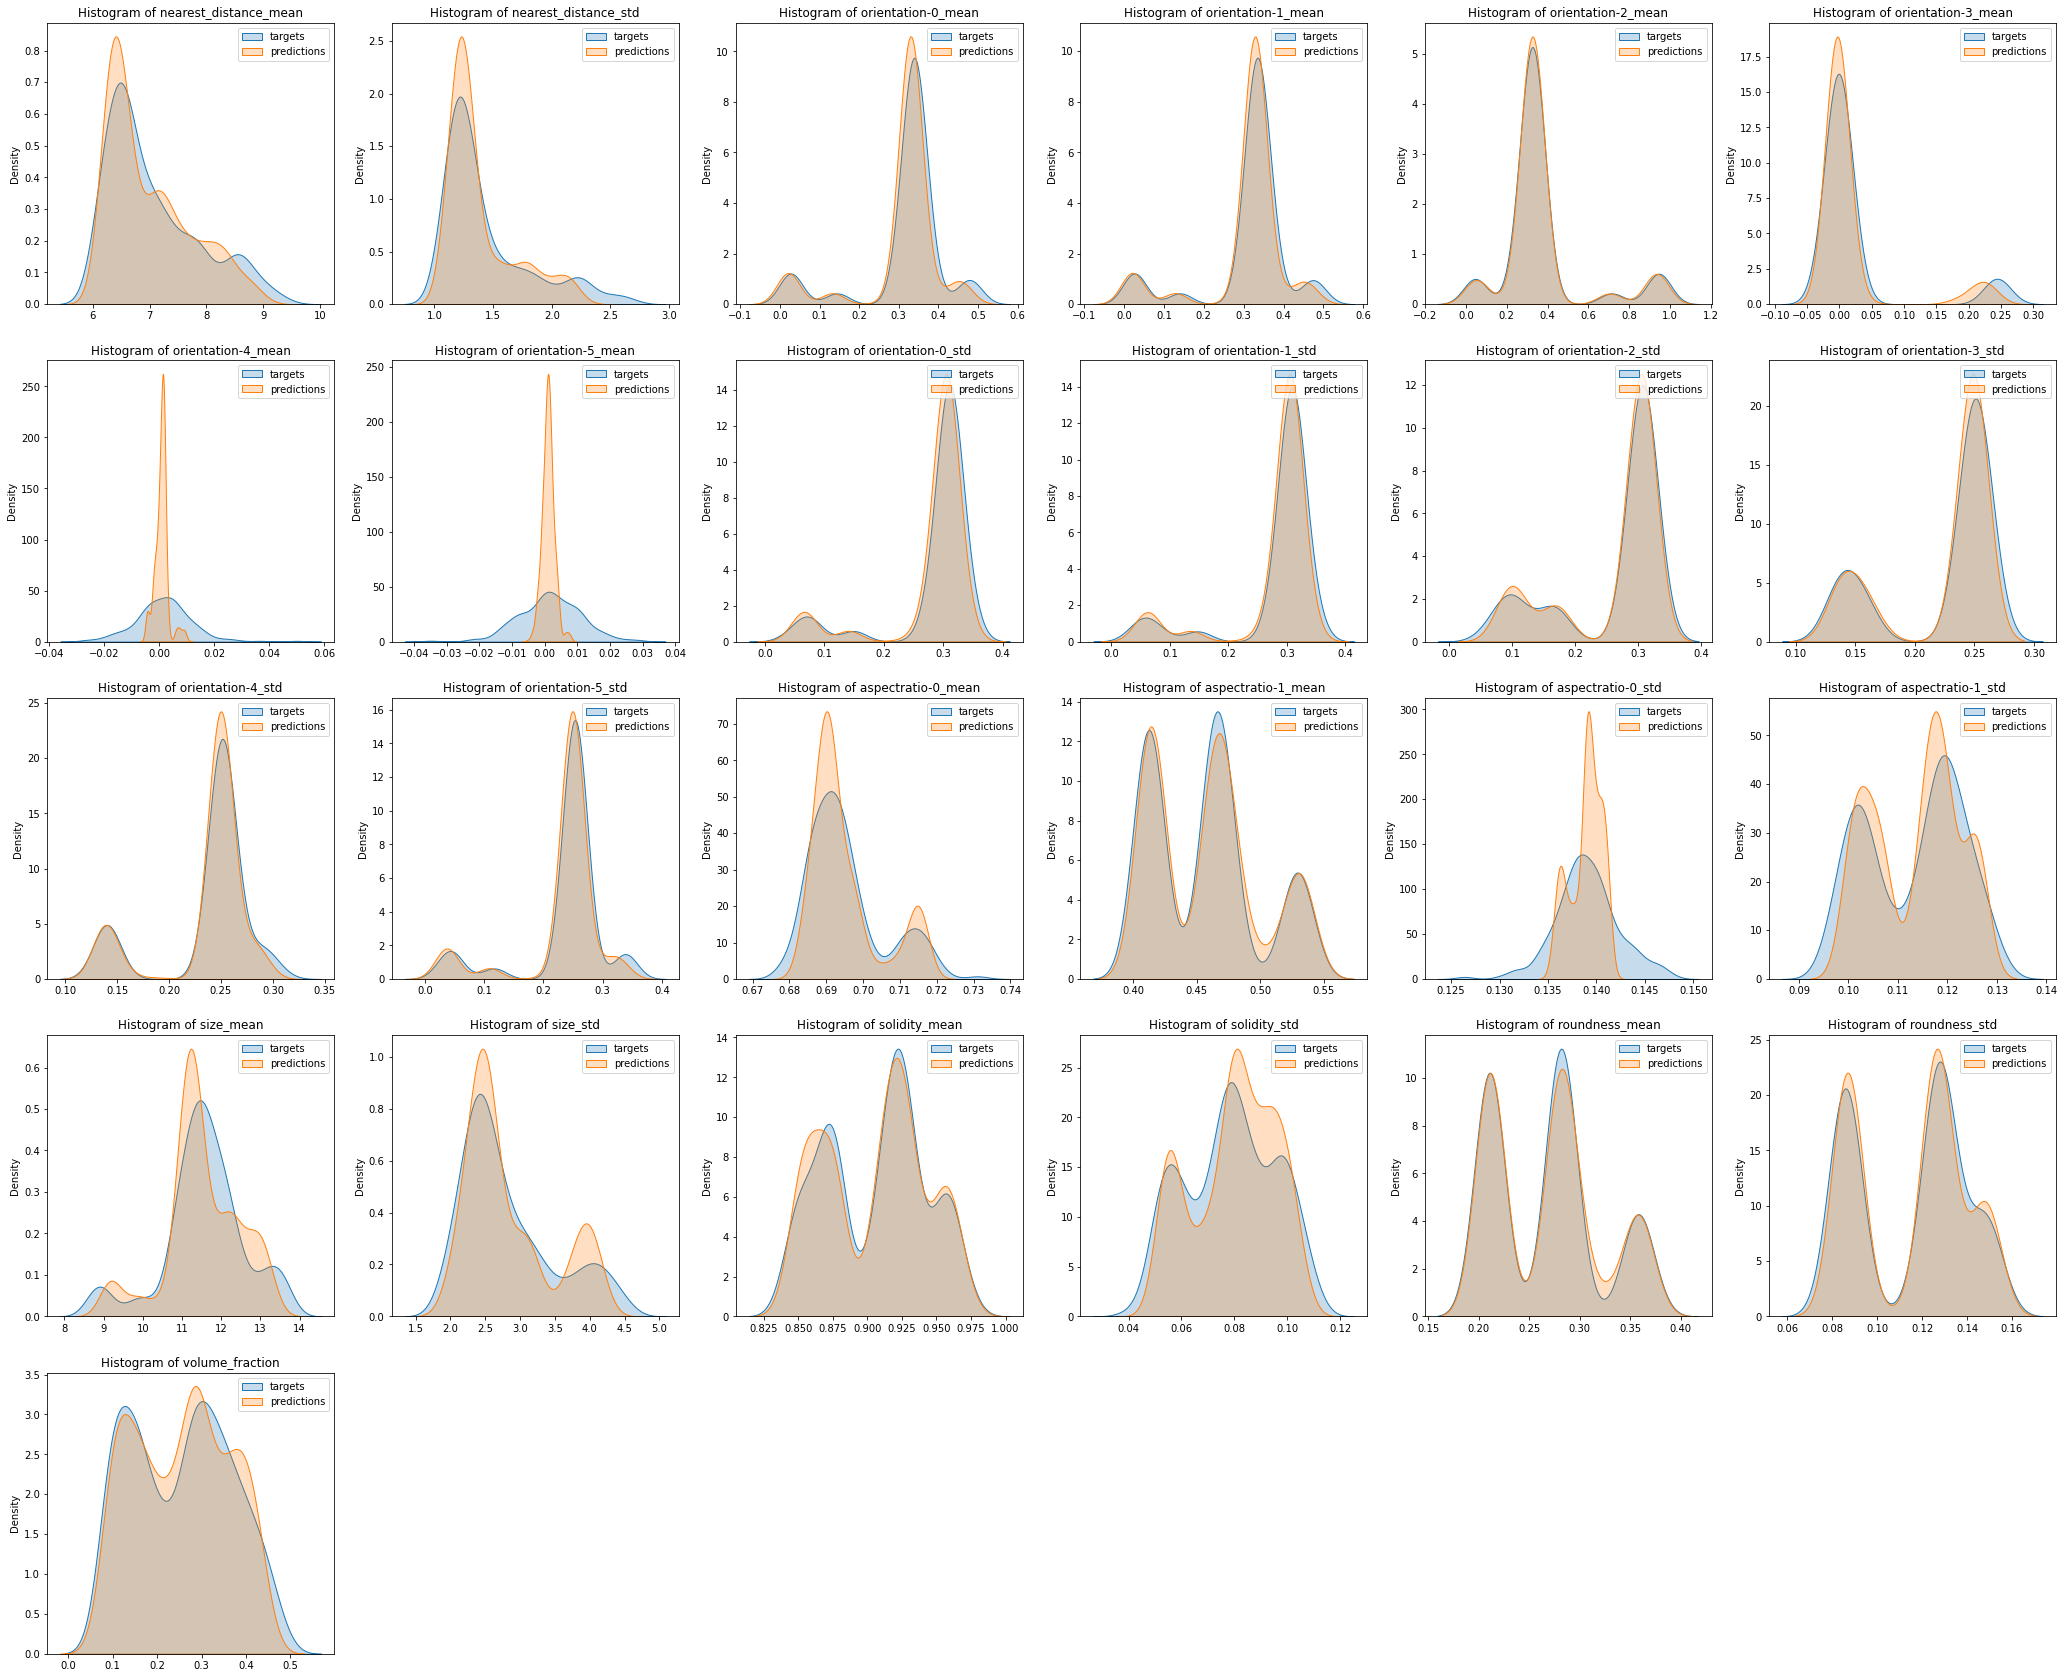

In [30]:
# %%capture
from typing import List, Union, Optional
import math


fig, axs = plotting.plot_kde(
    [
        dm.scaler.inverse_transform(targets.cpu().numpy()),
        dm.scaler.inverse_transform(predictions.cpu().numpy()),
    ],
    nb_hist_per_line=6,
    columns=dm.train_df.columns[1:-1],
    labels=["targets", "predictions"],
)


<AxesSubplot:>

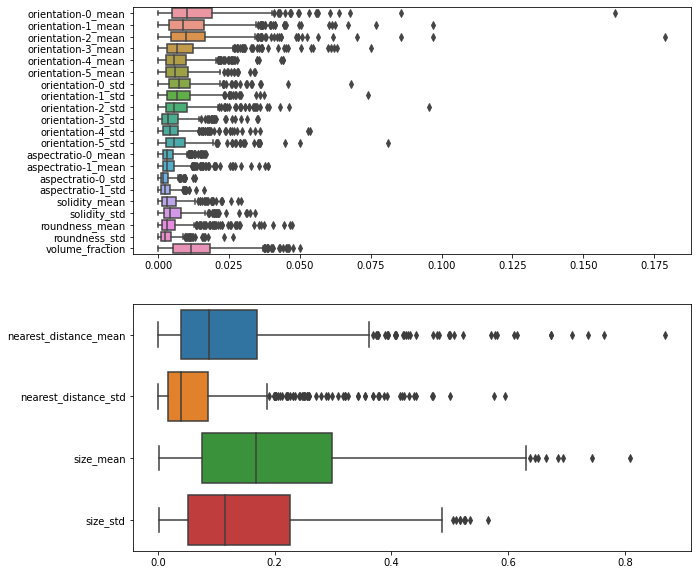

In [54]:
unnormalized_predictions = dm.scaler.inverse_transform(predictions)
unnormzalied_targets = dm.scaler.inverse_transform(targets)
mae = pd.DataFrame(
    np.abs(unnormalized_predictions - unnormzalied_targets),
    columns=dm.train_df.columns[1:-1],
)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.boxplot(
    data=mae.drop(
        labels=[
            "nearest_distance_mean",
            "nearest_distance_std",
            "size_mean",
            "size_std",
        ],
        axis=1,
    ),
    orient="h",
    ax=axes[0],
)
sns.boxplot(
    data=mae[
        ["nearest_distance_mean", "nearest_distance_std", "size_mean", "size_std"]
    ],
    orient="h",
    ax=axes[1],
)


/tmp/ipykernel_32614/2449180424.py:49: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dm.test_df.drop(


(0.0, 0.3)

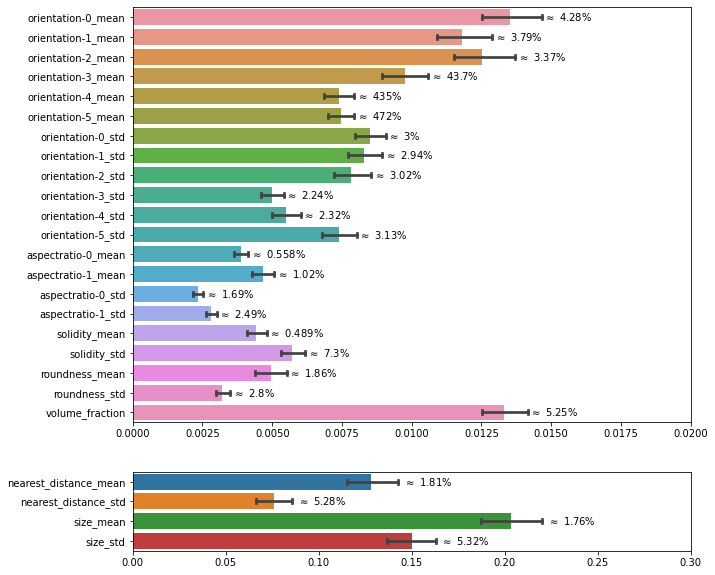

In [171]:
# unnormalized_predictions = dm.scaler.inverse_transform(predictions)
# unnormzalied_targets = dm.scaler.inverse_transform(targets)
# mae = pd.DataFrame(
#     np.abs(unnormalized_predictions - unnormzalied_targets),
#     columns=dm.train_df.columns[1:-1],
# )
fig, axes = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [21, 4]})
sns.barplot(
    data=mae.drop(
        labels=[
            "nearest_distance_mean",
            "nearest_distance_std",
            "size_mean",
            "size_std",
        ],
        axis=1,
    ),
    ci=95,
    capsize=0.2,
    orient="h",
    ax=axes[0],
)


def show_values_on_bars(axs, values, space=0.0001):
    def _show_on_single_plot(ax):
        i = 0
        index_patch = 0
        for index, p in enumerate(ax.lines):
            patch = ax.patches[index_patch]
            if index % 3 == 2:
                _x = p.get_xdata()[-1] + float(space)
                _y = patch.get_y() + patch.get_height() / 2
                value = r"$\mathregular{\bar{x}}$=" +"{0:.3g}".format(values[i])
                value = r"$\approx$ " + "{0:.3g}%".format(100*patch.get_width() / values[i])
                i += 1
                index_patch += 1
                ax.text(_x, _y, value, ha="left", va="center", fontsize=min(220/len(ax.patches), 10))

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


show_values_on_bars(
    axes[0],
    dm.test_df.drop(
        labels=[
            "nearest_distance_mean",
            "nearest_distance_std",
            "size_mean",
            "size_std",
        ],
        axis=1,
    ).mean(),
)

sns.barplot(
    data=mae[
        ["nearest_distance_mean", "nearest_distance_std", "size_mean", "size_std"]
    ],
    ci=99,
    capsize=0.2,
    orient="h",
    ax=axes[1],
)
show_values_on_bars(
    axes[1],
    dm.test_df[
        ["nearest_distance_mean", "nearest_distance_std", "size_mean", "size_std"]
    ].mean(),
    space=0.003
)
axes[0].set_xlim(right=0.02)
axes[1].set_xlim(right=0.3)

In [25]:
def compute_mae_per_descriptor(targets, predictions):
    return torch.mean(torch.abs(targets - predictions), axis=0).cpu().numpy()


def compute_average_correlation(df):
    corr_matrix = df.corr().to_numpy()
    return np.array(
        [
            np.mean(np.abs(np.delete(corr_matrix[i, :], i)))
            for i in range(len(corr_matrix))
        ]
    )


train_df = dm.train_df.drop(labels="id", axis=1)
mae_per_descriptor = compute_mae_per_descriptor(targets, predictions)
average_correlation = compute_average_correlation(train_df)

sorted_idx_mae = np.argsort(mae_per_descriptor)
print(f"Largest MAE on:\n\t{np.array(train_df.columns)[sorted_idx_mae][:4]}")

sorted_idx_corr = np.argsort(average_correlation)
print(f"Lowest correlation on:\n\t{np.array(train_df.columns)[sorted_idx_corr][:4]}")

idx_lowest_corr = np.argmin(average_correlation)
print(
    f"Average correlation of {np.array(train_df.columns)[idx_lowest_corr]}: {average_correlation[idx_lowest_corr]}"
)
print(
    f"Average correlation elsewhere {np.mean(np.delete(average_correlation, sorted_idx_corr[:-1]))}"
)


Largest MAE on:
	['orientation-1_mean' 'orientation-5_std' 'orientation-0_std'
 'orientation-3_std']
Lowest correlation on:
	['orientation-2_std' 'orientation-2_mean' 'orientation-5_mean' 'size_mean']
Average correlation of orientation-2_std: 0.04639711602938918
Average correlation elsewhere 0.37591321222261387


<AxesSubplot:>

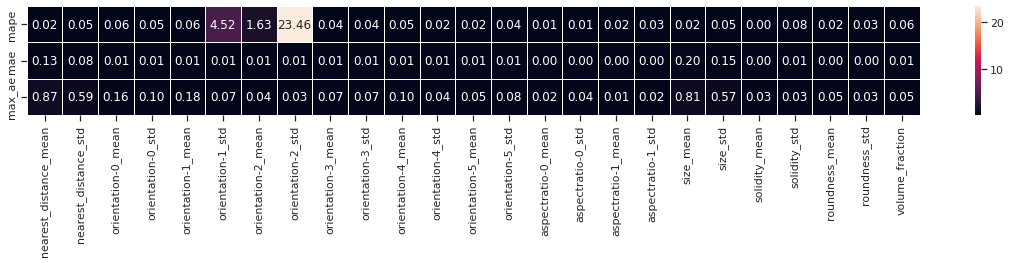

In [30]:
p = torch.Tensor(dm.scaler.inverse_transform(predictions))
t = torch.Tensor(dm.scaler.inverse_transform(targets))
mae = torch.mean(torch.abs(p - t), axis=0)
mape = torch.mean(torch.abs((p - t) / t), axis=0)
max_ae = torch.max(torch.abs(p - t), axis=0).values

data = pd.DataFrame.from_dict(
    {"mape": mape, "mae": mae, "max_ae": max_ae},
    columns=dm.train_df.columns[1:-1],
    dtype=float,
    orient="index",
)

fig = plt.figure(figsize=(20, 2))
sns.heatmap(
    data,
    annot=True,
    linewidths=0.5,
    fmt=".2f",
)


<Figure size 7200x7200 with 0 Axes>

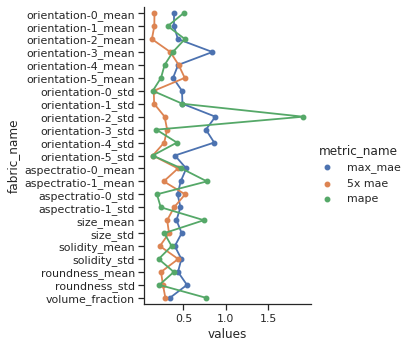

In [9]:
mae_df = pd.DataFrame(5 * mae, columns=["values"])
mae_df["metric_name"] = "5x mae"
mae_df["fabric_name"] = dm.train_df.columns[1:-1]
mape_df = pd.DataFrame(mape, columns=["values"])
mape_df["metric_name"] = "mape"
mape_df["fabric_name"] = dm.train_df.columns[1:-1]
max_ae_df = pd.DataFrame(max_ae, columns=["values"])
max_ae_df["metric_name"] = "max_mae"
max_ae_df["fabric_name"] = dm.train_df.columns[1:-1]

data = pd.concat([max_ae_df, mae_df, mape_df])
fig = plt.figure(figsize=(100, 100))
sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.catplot(data=data, y="fabric_name", x="values", hue="metric_name", kind="point")
